In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy
from keras.applications.resnet50 import preprocess_input
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score
from keras.utils import Sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [117]:
def dataframe():
    df = pd.read_csv(PATH_DF_CSV)
    df.rename(columns = {'image':'id_code', 'level':'diagnosis'}, inplace = True)
    return df

def create_path(s):
    df = dataframe()
    x = df['id_code']
    y = df['diagnosis']
    paths = []
    for i in x[:subset]:
        path = PATH_OF_IMAGE+f'{i}.jpeg'
        paths.append(path)
    return paths

def load_data(subset):
    paths = create_path()
    imgs = []
    for path in paths:
        img = cv2.imread(path)
        imgs.append(np.array(img))
    X = np.array(imgs)
    return X

def preprocessing_1_autocropping(sigmaX=10):
    """
    Create circular crop around image centre and applies Ben Graham's color
    """

    X = load_data()

    images = []

    for image in X:
        img = first_cropping(image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        height, width, depth = img.shape

        x = int(width/2)
        y = int(height/2)
        r = np.amin((x,y))

        circle_img = np.zeros((height, width), np.uint8)
        cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
        img = cv2.bitwise_and(img, img, mask=circle_img)
        img = first_cropping(img)
        img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)

        images.append(np.array(img))

    preprocessed_X_autocropping = np.array(images)
    return preprocessed_X_autocropping

def first_cropping(img,tol=7):
    '''
    tol is tolerance, img is image data, creates first cropping
    '''

    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol

        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]

            img = np.stack([img1,img2,img3],axis=-1)

        return img

def preprocessing_2_same_size():
    X = load_data()
    images = []
    for image in X:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = first_cropping(image)
        image = cv2.resize(image, (512, 512))
        image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , 10) ,-4 ,128)
        images.append(np.array(image))

    preprocessed_X_same_size = np.array(images)

    return preprocessed_X_same_size

In [90]:
PATH_OF_IMAGE = "/Users/jade/code/lucieluneau/blindness_detection/raw_data/bidon/"
paths = []
for i in range(1,6,1):
    path = PATH_OF_IMAGE+f'{i}.jpeg'
    paths.append(path)

In [91]:
paths

['/Users/jade/code/lucieluneau/blindness_detection/raw_data/bidon/1.jpeg',
 '/Users/jade/code/lucieluneau/blindness_detection/raw_data/bidon/2.jpeg',
 '/Users/jade/code/lucieluneau/blindness_detection/raw_data/bidon/3.jpeg',
 '/Users/jade/code/lucieluneau/blindness_detection/raw_data/bidon/4.jpeg',
 '/Users/jade/code/lucieluneau/blindness_detection/raw_data/bidon/5.jpeg']

(163, 161, 3)


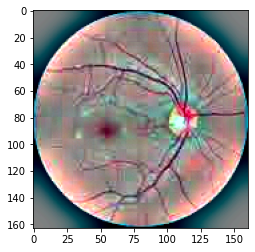

(194, 195, 3)


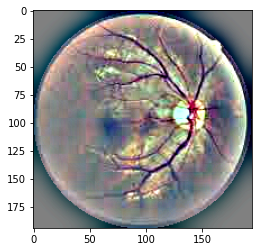

(179, 179, 3)


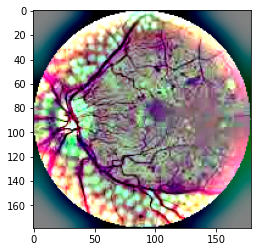

(190, 193, 3)


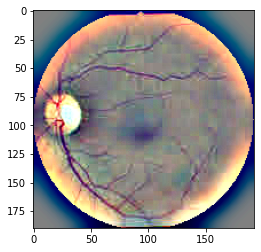

(434, 433, 3)


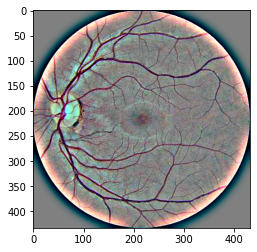

In [92]:
for path in paths:

    img = cv2.imread(path)
    img = first_cropping(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    height, width, depth = img.shape

    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = first_cropping(img)
    img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , 10) ,-4 ,128)
    print(img.shape)
    plt.imshow(img)
    plt.show()

In [22]:
img.shape

(163, 161, 3)

In [23]:
def dataframe():
    df = pd.read_csv(PATH_DF_CSV)
    return df

def create_path(id_code):
    df = dataframe()
    x = df['id_code']
    y = df['diagnosis']
    paths = []
    for i in x:
        path = PATH_OF_IMAGE+f'{i}.jpeg'
        paths.append(path)
    
    imgs = []
    for path in paths: 
        img = Image.open(path)
        imgs.append(np.array(img))
    return paths

In [75]:
paths

['/Users/jade/code/lucieluneau/blindness_detection/raw_data/bidon/1.jpeg',
 '/Users/jade/code/lucieluneau/blindness_detection/raw_data/bidon/2.jpeg',
 '/Users/jade/code/lucieluneau/blindness_detection/raw_data/bidon/3.jpeg',
 '/Users/jade/code/lucieluneau/blindness_detection/raw_data/bidon/4.jpeg',
 '/Users/jade/code/lucieluneau/blindness_detection/raw_data/bidon/5.jpeg']

In [76]:
imgs = []
for path in paths: 
    img = cv2.imread(path)
    imgs.append(np.array(img))
    
X = np.array(imgs)

In [77]:
X

array([array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8),
       array([[[26, 24, 36],
        [26, 24, 36],
        [26, 24, 36],
        ...,
        [26, 24, 36],
        [27, 25, 37],
        [27, 25, 37]],

       [[26, 24, 36],
        [25, 23,

1


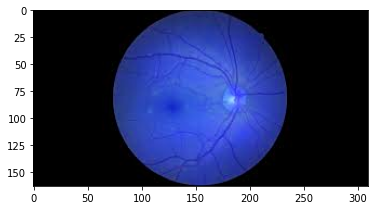

1


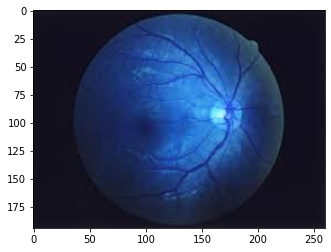

1


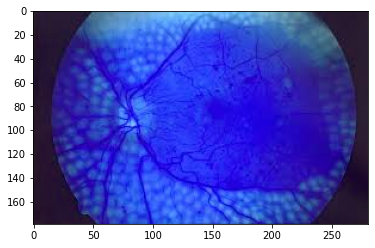

1


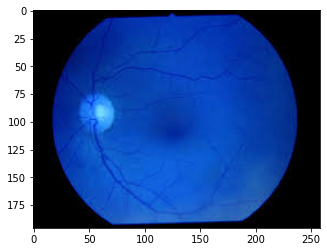

1


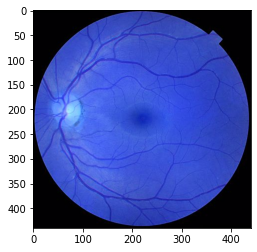

In [45]:
for img in X:
    print(1)
    plt.imshow(img)
    plt.show()

In [108]:
images = []
for image in X:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = first_cropping(image)
    image = cv2.resize(image, (512, 512))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , 10) ,-4 ,128)
    images.append(np.array(image))
preprocessed_X = np.array(images)

In [109]:
preprocessed_X.shape

(5, 512, 512, 3)

(512, 512, 3)


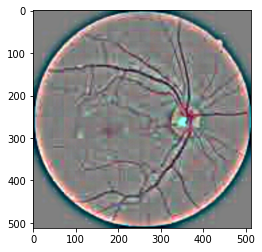

(512, 512, 3)


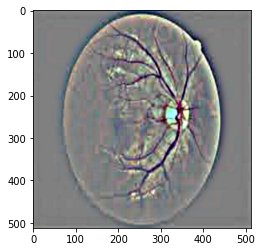

(512, 512, 3)


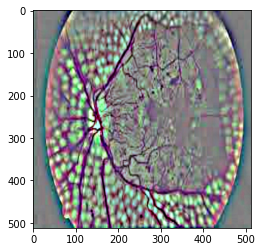

(512, 512, 3)


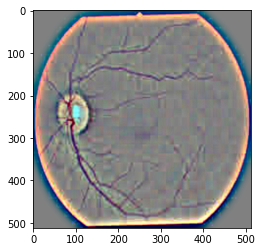

(512, 512, 3)


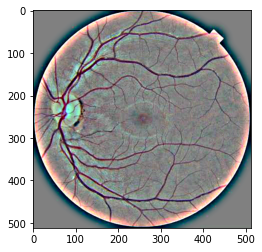

In [110]:
for img in preprocessed_X: 
    print(img.shape)
    plt.imshow(img)
    plt.show()